In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

In [2]:
df = pd.read_csv("avito_train.tsv",sep='\t')

In [3]:
print df.shape, df.is_blocked.mean()
df[:5]

(3995803, 13) 0.0688212106553


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000025,Услуги,Предложения услуг,Монтаж кровли,Выполняем монтаж кровли фальцевой ^p Тел:8@@P...,"{""Вид услуги"":""Ремонт, строительство""}",0,NaN,0,1,0,0,22.38
2,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
3,10000101,Транспорт,Автомобили с пробегом,"Ford Focus, 2011","Автомобиль в отличном техническом состоянии, в...","{""Марка"":""Ford"", ""Модель"":""Focus"", ""Год выпуск...",365000,NaN,0,0,0,0,8.87
4,10000132,Транспорт,Запчасти и аксессуары,Турбина 3.0 Bar,Продам турбину на двигатель V-6 . V-8 и мощнее...,"{""Вид товара"":""Запчасти"", ""Тип товара"":""Для ав...",5000,NaN,0,0,0,0,11.82


In [4]:
print "Blocked ratio",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio 0.0688212106553
Count: 3995803


## Balance-out the classes

In [5]:
def downsampleDataset(df):
    indexes = [i for i,val in enumerate(df.is_blocked) if val != 0]
    notBlocked = [i for i,val in enumerate(df.is_blocked) if val == 0]
    indexes.extend(np.random.choice(notBlocked, len(indexes), replace=False))
    return df.loc[indexes]

In [6]:
df = downsampleDataset(df)


print "Blocked ratio:",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio: 0.5
Count: 549992


In [7]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print "All tests passed"

All tests passed


## Tokenizing

In [8]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1

In [9]:
print "Unique keys:", len(token_counts.keys())

Unique keys: 520990


### Remove rare tokens

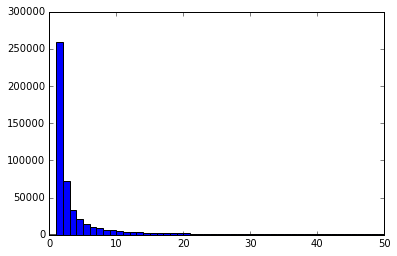

In [10]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [11]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 10
tokens = [token for token in token_counts.keys() if token_counts[token] >= min_count]

In [12]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0

In [13]:
print "# Tokens:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc"
if len(token_to_id) > 1000000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 87815


### Replace words with IDs

Set a maximum length for titles and descriptions.

* If string is longer that that limit - crop it, if less - pad with zeros.
* Thus we obtain a matrix of size [n_samples]x[max_length]
* Element at i,j - is an identifier of word j within sample i

In [14]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [15]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

In [16]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (549992, 15)
Поездки на таможню, печать в паспорте -> [43256 14662 55278 81971 80069 17315     0     0     0     0] ...
Рефлекторно-урогинекологический массаж -> [ 8344     0 30437     0     0     0     0     0     0     0] ...
Возьму суду под200 т. р -> [28798 23377     0  3665 33922     0     0     0     0     0] ...


## Non-sequences

In [17]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]
data_cat_subcat = df[["category","subcategory"]].values

In [18]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values

categories =[{"category":category_name, "subcategory":subcategory_name} \
             for category_name, subcategory_name in data_cat_subcat ]
vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [19]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Split data into training and test

In [20]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [21]:
from sklearn.model_selection import ShuffleSplit
#Split into training and test set.


#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard

rs = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
for indexes_train, indexes_test  in rs.split(title_tokens):
    

    title_tr = np.array([title_tokens[i] for i in indexes_train])
    title_ts = np.array([title_tokens[i] for i in indexes_test])
    desc_tr =  np.array([desc_tokens[i] for i in indexes_train])
    desc_ts =  np.array([desc_tokens[i] for i in indexes_test])
    nontext_tr = np.array(df_non_text.iloc[indexes_train])
    nontext_ts =  np.array(df_non_text.iloc[indexes_test])
    target_tr = np.array([target[i] for i in indexes_train])
    target_ts =  np.array([target[i] for i in indexes_test])



## NN architecture

In [23]:
#libraries
import lasagne
from theano import tensor as T
import theano

In [24]:

#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

In [25]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [ ]:
# Descriptions
number = 64
#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=number)
descr_nn = lasagne.layers.LSTMLayer(descr_nn,64 )

# Titles
title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1, output_size=number)
title_nn = lasagne.layers.LSTMLayer(title_nn, 64)

# Non-sequences
cat_nn = lasagne.layers.GRULayer(cat_inp, number)

Тут сначала не использовала нечисловые признаки. Позже запустила с числовыми, и, действительно, без них оказалось лучше.

In [27]:
nn = lasagne.layers.concat([descr_nn, title_nn])# <merge three layers into one (e.g. lasagne.layers.concat) >                                  
print nn.output_shape

(None, 165, 64)


In [28]:

nn = lasagne.layers.DenseLayer(nn,64)
nn = lasagne.layers.DropoutLayer(nn,p=0.5)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

In [29]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [30]:
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

In [31]:
#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y,delta =1 ).mean()

In [32]:
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]
#Hinge loss
det_loss = lasagne.objectives.binary_hinge_loss(det_prediction,target_y,delta =1 ).mean()

In [33]:
#Weight optimization step
updates = lasagne.updates.adadelta(loss, weights)
#updates = lasagne.updates.adadelta(loss_train, all_params)

In [34]:
train_fun = theano.function([desc_token_ids,title_token_ids,target_y],[loss,prediction],updates = updates)

In [35]:
eval_fun = theano.function([desc_token_ids,title_token_ids,target_y],[det_loss,det_prediction])

In [36]:
#average precision at K

from oracle import APatK, score

In [37]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

## Train

In [38]:
from sklearn.metrics import roc_auc_score, accuracy_score

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100

for i in range(n_epochs):
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    #print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

Train:
	loss: 0.864696721522
	acc: 0.596534653465
	auc: 0.643573037034
Val:
	loss: 0.764258313031
	acc: 0.648217821782
	auc: 0.875010719689
	ap@k: 0.99164756436
Train:
	loss: 0.488303093047
	acc: 0.79603960396
	auc: 0.879005975908
Val:
	loss: 0.355185203504
	acc: 0.860594059406
	auc: 0.938052484355
	ap@k: 1.0
Train:
	loss: 0.351300105209
	acc: 0.853861386139
	auc: 0.93052008221
Val:
	loss: 0.316821248845
	acc: 0.861485148515
	auc: 0.946163521273
	ap@k: 0.998776659036
Train:
	loss: 0.273409001672
	acc: 0.891683168317
	auc: 0.953693336318
Val:
	loss: 0.241953628912
	acc: 0.900891089109
	auc: 0.968014759408
	ap@k: 0.988199956186
Train:
	loss: 0.245245072665
	acc: 0.899801980198
	auc: 0.962713537096
Val:
	loss: 0.244623440317
	acc: 0.89900990099
	auc: 0.964838834011
	ap@k: 0.985982487608
Train:
	loss: 0.202843000562
	acc: 0.91801980198
	auc: 0.971709382368
Val:
	loss: 0.195683669133
	acc: 0.919900990099
	auc: 0.975883270611
	ap@k: 0.99930268158
Train:
	loss: 0.191344739806
	acc: 0.92366336

## Final evaluation

In [40]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

 Scores:
	loss: 0.0938195829858
	acc: 0.96385007278
	auc: 0.992700494464
	ap@k: 0.998638497952

AUC:
	Пиши статью. (great)

Accuracy:
	Отличный результат! (good)

Average precision at K:
	Засабмить на kaggle! (great) 
	 Нет, ну честно - выкачай avito_test.tsv, засабмить и скажи, что вышло.
